In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
import statsmodels as sm
import time
from sklearn.model_selection import KFold
MAX_EVALS = 500
N_FOLDS = 10

In [2]:
#I merged the excel files prior for ease of access
pd.set_option('display.max_columns', None)
origin_comp = pd.read_csv('tic_origin.csv')

#separating data into 
train = origin_comp[origin_comp['ORIGIN'] == 'train']
test = origin_comp[origin_comp['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

#https://www.kaggle.com/kushshah95/the-insurance-company-tic-benchmark

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA,PWAPART,PWABEDR,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,0,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


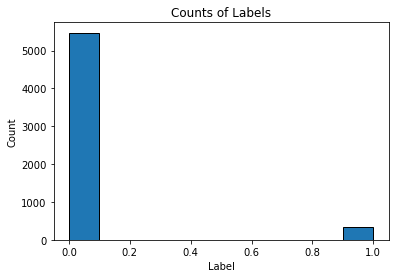

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

# First thoughts:

This is an imbalanced class problem since there are more observations where there is no insurance policy (0) compared to where there is an insurance policy (1). This being the case, ROC and AUC becomes an important factor in how we determine accuracy. A resampling method such as upsampling/downsampling, can be used on the majority observation to deal with this issue as well.


### In this problem, I will use resampling, hyperparameter tuning, and feature selection to achieve better results

In [ ]:
train.describe()

In [ ]:
#renaming variables to easy reading
train.rename(columns={'MOSTYPE': 'subtype_L0', 'MAANTHUI':'Num_houses', 'MGEMOMV' : 'Avg_hh_size',
                   'MGEMLEEF':'age_L1', 'MOSHOOFD': 'maintype_L2', 'MGODRK': 'romcath_L3',
                   'MGODPR': 'Protestant','MGODOV' : 'O_religion', 'MGODGE': 'N_religion','MRELGE' :'Married',
                   'MRELSA' : 'Living_together','MRELOV' : 'O_relation','MFALLEEN' : 'Singles','MFGEKIND' : 'hh_wo_child',
                   'MFWEKIND' : 'hh_w_child','MOPLHOOG' : 'H_lvl_edu','MOPLMIDD' : 'M_lvl_edu',
                   'MOPLLAAG' : 'L_lvl_edu','MBERHOOG' : 'H_status','MBERZELF' : 'Entrepreneur','MBERBOER' : 'Farmer',
                   'MBERMIDD' : 'Mid_management','MBERARBG' : 'Skld_labor','MBERARBO' : 'Unskld_labor',
                   'MSKA' : 'Soc_cls_A','MSKB1' : 'Soc_cls_B1','MSKB2' : 'Soc_cls_B2','MSKC' : 'Soc_cls_C',
                   'MSKD' : 'Soc_cls_D','MHHUUR' : 'R_house','MHKOOP' : 'O_house','MAUT1' : '1_car','MAUT2' : '2_cars',
                   'MAUT0' : 'N_car','MZFONDS' : 'Nat_Hlth_Serv','MZPART' : 'Prv_Hlth_Insur','MINKM30' : 'Inc_u_30k',
                   'MINK3045' : 'Inc_btw_30_45k','MINK4575' : 'Inc_btw_45_75k','MINK7512' : 'Inc_75_122k','MINK123M' : 'Inc_ovr_123k',
                   'MINKGEM' : 'Avg_inc','MKOOPKLA' : 'PP_cls','PWAPART' : 'Contri_prv_3p_insur_L4','PWABEDR' : 'Firm_Contri_3p_ insur',
                   'PWALAND' : 'Ag_Contri_3p_insur','PPERSAUT' : 'Contri_car_pol','PBESAUT' : 'Contri_deliv_van_pol',
                   'PMOTSCO' : 'Contri_motorcycle/scooter_pol','PVRAAUT' : 'Contri_lorry_pol','PAANHANG' : 'Contri_trailer_pols',
                   'PTRACTOR' : 'Contri_tractor_pol','PWERKT' : 'Contri_ag_machine_pol','PBROM' : 'Contri_moped_pol',
                   'PLEVEN' : 'Contri_life_insur','PPERSONG' : 'Contri_prv_accid_insur_pol',
                   'PGEZONG' : 'Contri_fam_accid_insur_pol','PWAOREG' : 'Contri_disabl_insur_pol','PBRAND' : 'Contri_fire_pol',
                   'PZEILPL' : 'Contri_surfb_pol','PPLEZIER' : 'Contri_boat_pol','PFIETS' : 'Contri_bike_pol',
                   'PINBOED' : 'Contri_prop_insur_pol','PBYSTAND' : 'Contri_ss_insur_polo','AWAPART' : 'Num_prv_3p_insur',
                   'AWABEDR' : 'Num_firm_3p_insur','AWALAND' : 'Num_ag_3p_insur','APERSAUT' : 'Num_car_pol',
                   'ABESAUT' : 'Num_deliv_van_pol','AMOTSCO' : 'Num_motorcycle/scooter_pol', 'AVRAAUT' : 'Num_lorry_pol','AAANHANG': 'Num_trailer_pol',
                   'ATRACTOR' : 'Num_tractor_pol','AWERKT' : 'Num_ag_machines_pol','ABROM' : 'Num_moped_pol',
                   'ALEVEN' : 'Num_life_insur_pol', 'APERSONG' : 'Num_prv_accid_insur_pol','AGEZONG' : 'Num_fam_ccid_insur_pol',
                   'AWAOREG' : 'Num_disabl_insur_pol','ABRAND' :'Num_fire_pol','AZEILPL' :'Num_surfb_pol','APLEZIER' :'Num_boat_pol',
                   'AFIETS' :'Num_bike_pol','AINBOED' :'Num_prop_insur_pol','ABYSTAND' :'num_ss_insur_pol'},
          inplace=True)

test.rename(columns={'MOSTYPE': 'subtype_L0', 'MAANTHUI':'Num_houses', 'MGEMOMV' : 'Avg_hh_size',
                   'MGEMLEEF':'age_L1', 'MOSHOOFD': 'maintype_L2', 'MGODRK': 'romcath_L3',
                   'MGODPR': 'Protestant','MGODOV' : 'O_religion', 'MGODGE': 'N_religion','MRELGE' :'Married',
                   'MRELSA' : 'Living_together','MRELOV' : 'O_relation','MFALLEEN' : 'Singles','MFGEKIND' : 'hh_wo_child',
                   'MFWEKIND' : 'hh_w_child','MOPLHOOG' : 'H_lvl_edu','MOPLMIDD' : 'M_lvl_edu',
                   'MOPLLAAG' : 'L_lvl_edu','MBERHOOG' : 'H_status','MBERZELF' : 'Entrepreneur','MBERBOER' : 'Farmer',
                   'MBERMIDD' : 'Mid_management','MBERARBG' : 'Skld_labor','MBERARBO' : 'Unskld_labor',
                   'MSKA' : 'Soc_cls_A','MSKB1' : 'Soc_cls_B1','MSKB2' : 'Soc_cls_B2','MSKC' : 'Soc_cls_C',
                   'MSKD' : 'Soc_cls_D','MHHUUR' : 'R_house','MHKOOP' : 'O_house','MAUT1' : '1_car','MAUT2' : '2_cars',
                   'MAUT0' : 'N_car','MZFONDS' : 'Nat_Hlth_Serv','MZPART' : 'Prv_Hlth_Insur','MINKM30' : 'Inc_u_30k',
                   'MINK3045' : 'Inc_btw_30_45k','MINK4575' : 'Inc_btw_45_75k','MINK7512' : 'Inc_75_122k','MINK123M' : 'Inc_ovr_123k',
                   'MINKGEM' : 'Avg_inc','MKOOPKLA' : 'PP_cls','PWAPART' : 'Contri_prv_3p_insur_L4','PWABEDR' : 'Firm_Contri_3p_ insur',
                   'PWALAND' : 'Ag_Contri_3p_insur','PPERSAUT' : 'Contri_car_pol','PBESAUT' : 'Contri_deliv_van_pol',
                   'PMOTSCO' : 'Contri_motorcycle/scooter_pol','PVRAAUT' : 'Contri_lorry_pol','PAANHANG' : 'Contri_trailer_pols',
                   'PTRACTOR' : 'Contri_tractor_pol','PWERKT' : 'Contri_ag_machine_pol','PBROM' : 'Contri_moped_pol',
                   'PLEVEN' : 'Contri_life_insur','PPERSONG' : 'Contri_prv_accid_insur_pol',
                   'PGEZONG' : 'Contri_fam_accid_insur_pol','PWAOREG' : 'Contri_disabl_insur_pol','PBRAND' : 'Contri_fire_pol',
                   'PZEILPL' : 'Contri_surfb_pol','PPLEZIER' : 'Contri_boat_pol','PFIETS' : 'Contri_bike_pol',
                   'PINBOED' : 'Contri_prop_insur_pol','PBYSTAND' : 'Contri_ss_insur_polo','AWAPART' : 'Num_prv_3p_insur',
                   'AWABEDR' : 'Num_firm_3p_insur','AWALAND' : 'Num_ag_3p_insur','APERSAUT' : 'Num_car_pol',
                   'ABESAUT' : 'Num_deliv_van_pol','AMOTSCO' : 'Num_motorcycle/scooter_pol', 'AVRAAUT' : 'Num_lorry_pol','AAANHANG': 'Num_trailer_pol',
                   'ATRACTOR' : 'Num_tractor_pol','AWERKT' : 'Num_ag_machines_pol','ABROM' : 'Num_moped_pol',
                   'ALEVEN' : 'Num_life_insur_pol', 'APERSONG' : 'Num_prv_accid_insur_pol','AGEZONG' : 'Num_fam_ccid_insur_pol',
                   'AWAOREG' : 'Num_disabl_insur_pol','ABRAND' :'Num_fire_pol','AZEILPL' :'Num_surfb_pol','APLEZIER' :'Num_boat_pol',
                   'AFIETS' :'Num_bike_pol','AINBOED' :'Num_prop_insur_pol','ABYSTAND' :'num_ss_insur_pol'},
          inplace=True)

In [ ]:
#Dataset had been pre-encoded to remove strings, but further improvements can be made to make the data more readable.
train.head()

In [ ]:
test.head()

In [ ]:
#Original dataset getting dummies.
pre_enc= ['subtype_L0', 'age_L1', 'maintype_L2']
post_enc_df = pd.get_dummies(df_td, prefix_sep="_", columns=pre_enc)

# Rebalancing data for a 5-1 ratio

In [ ]:
from sklearn.utils import resample

#Creating a 5-1 ratio to test how this effects that data.
# separate minority and majority classes
no_policy = post_enc_df[post_enc_df.Target==0][:1740]
has_policy = post_enc_df[post_enc_df.Target==1]

# combine majority and upsampled minority
upsampled = pd.concat([no_policy, has_policy])

new_df = upsampled.sample(frac=1)

# check new class counts
print(new_df.Target.value_counts())
print(new_df.shape)

In [ ]:
#importing required modules to see impacts of different feature selection methods
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_roc_curve, classification_report, balanced_accuracy_score, coverage_error
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer

start = timer()
train_time = timer() - start

def clf_model_comp(df):
    classifiers = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=15, min_samples_split=5),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    lgb.LGBMClassifier(),
    MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    ]
    
    # Separating out the features
    X =  features
    # Separating out the target
    y = labels
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)    
    
    for classifier in classifiers:
        scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_macro')
        model = classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        print(classifier)
        print('The Training F1 Score is', f1_score(classifier.predict(X_train), y_train))
        print('The Testing F1 Score is', f1_score(predictions, y_test))
        print("accuracy score" '\n', accuracy_score(y_test, predictions))
        print("balanced_accuracy_score" '\n', balanced_accuracy_score(y_test, predictions))
        print("model confusion matrix" '\n', confusion_matrix(y_test, predictions, normalize='all'))
        print("classification_report" '\n', classification_report(y_test, predictions),'\n')
        ax = plt.gca()
        plt.rcParams['figure.figsize'] = (10, 10)
        disp = plot_roc_curve(classifier, X_test, y_test, ax=ax, alpha=0.9)

In [ ]:
clf_model_comp(train)

# Selecting the important features for the dataset

I will use the Embedded method and then Chi-squared to select features in the dataset in order to narrow down my search.

In [ ]:
# Separating out the features
X =  new_df.drop('Target', axis=1) #df_td.drop('Target', axis=1)# train_feat
# Separating out the target
y = new_df.Target #df_td.Target#target_feat

In [ ]:
#First I am using the Embedded method to narrow down my search. 
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV(max_iter = 10000, tol=0.00001)
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

In [ ]:
LassoCV().get_params().keys()

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


In [ ]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 30)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
coef

In [ ]:
lasso_col = new_df[['Contri_boat_pol', 'Contri_prv_3p_insur_L4_2', 'Contri_car_pol', 'subtype_L0_8',
                   'Contri_disabl_insur_pol','H_lvl_edu','Contri_fire_pol','Contri_ss_insur_polo','Inc_75_122k','Mid_management',
                   'Protestant','Soc_cls_C','PP_cls','1_car','Married','maintype_L2_2','H_status','Inc_btw_30_45k','Avg_inc','M_lvl_edu',
                   'Nat_Hlth_Serv','O_religion','Skld_labor','Prv_Hlth_Insur','maintype_L2_3','R_house','L_lvl_edu','Farmer','Living_together',
                   'Ag_Contri_3p_insur','Inc_ovr_123k', 'Target']]

In [ ]:
print(coef)

In [ ]:
clf_model_comp(lasso_col)

In [ ]:
soec_df = df_td.drop(df_td.iloc[:, 42:85])

In [ ]:
#Now using the Chi-Squared method
from sklearn.feature_selection import chi2


chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
matplotlib.rcParams['figure.figsize'] = (30, 10)
p_values.plot.bar()

# Automated Hyperparameter tuning using Hyperopt for GradientBoosting

In [4]:
import lightgbm as lgb
from timeit import default_timer as timer
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier()

In [5]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7092.
The baseline training time is 0.2594 seconds


In [6]:
import random

In [7]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

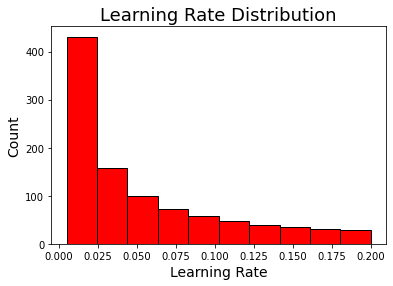

In [8]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

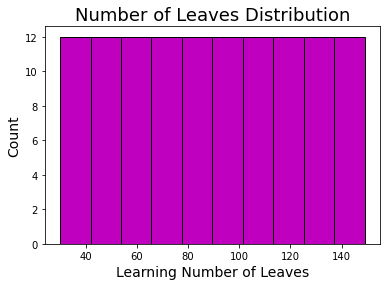

In [9]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

In [10]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 77,
 'learning_rate': 0.10175588757202289,
 'subsample_for_bin': 40000,
 'min_child_samples': 315,
 'reg_alpha': 0.22448979591836732,
 'reg_lambda': 0.9387755102040816,
 'colsample_bytree': 0.9555555555555555}

In [11]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 77,
 'learning_rate': 0.10175588757202289,
 'subsample_for_bin': 40000,
 'min_child_samples': 315,
 'reg_alpha': 0.22448979591836732,
 'reg_lambda': 0.9387755102040816,
 'colsample_bytree': 0.9555555555555555,
 'subsample': 1.0}

In [12]:
# Create a lgb dataset
train_set = lgb.Dataset(features, label = labels)

In [13]:
# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.75142 with std of 0.04465.
The ideal number of iterations was 9.


In [14]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [15]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

In [ ]:

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 76, 'learning_rate': 0.055533968216953146, 'subsample_for_bin': 80000, 'min_child_samples': 460, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 1.0, 'colsample_bytree': 0.8222222222222222}
{'class_weight': None, 'boosting_type': 'goss', 'num_leaves': 58, 'learning_rate': 0.06437322298735856, 'subsample_for_bin': 180000, 'min_child_samples': 70, 'reg_alpha': 0.18367346938775508, 'reg_lambda': 0.44897959183673464, 'colsample_bytree': 0.6444444444444444}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 58, 'learning_rate': 0.010197109660117238, 'subsample_for_bin': 40000, 'min_child_samples': 230, 'reg_alpha': 0.7755102040816326, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.8666666666666667}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 118, 'learning_rate': 0.048981732603349946, 'subsample_for_bin': 280000, 'min_child_samples': 230, 'reg_alpha': 0.8979591836734693, 'reg_lambd

{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 98, 'learning_rate': 0.005149906136788399, 'subsample_for_bin': 160000, 'min_child_samples': 205, 'reg_alpha': 0.3877551020408163, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 1.0}
{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 105, 'learning_rate': 0.008384610951889282, 'subsample_for_bin': 20000, 'min_child_samples': 355, 'reg_alpha': 0.26530612244897955, 'reg_lambda': 0.5102040816326531, 'colsample_bytree': 0.8666666666666667}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 73, 'learning_rate': 0.016178380545832607, 'subsample_for_bin': 120000, 'min_child_samples': 215, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.6444444444444444}
{'class_weight': None, 'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.14451322534564692, 'subsample_for_bin': 220000, 'min_child_samples': 295, 'reg_alpha': 0.5306122448979591, 'reg_lamb

{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.007127245446872905, 'subsample_for_bin': 100000, 'min_child_samples': 70, 'reg_alpha': 0.8979591836734693, 'reg_lambda': 0.6326530612244897, 'colsample_bytree': 0.7333333333333333}
{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.04600148599214018, 'subsample_for_bin': 140000, 'min_child_samples': 275, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.9387755102040816, 'colsample_bytree': 0.6444444444444444}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 52, 'learning_rate': 0.07244734769700005, 'subsample_for_bin': 140000, 'min_child_samples': 275, 'reg_alpha': 0.8571428571428571, 'reg_lambda': 0.6938775510204082, 'colsample_bytree': 0.8222222222222222}
{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.037270312367259056, 'subsample_for_bin': 120000, 'min_child_samples': 310, 'reg_alpha': 0.9591836734693

{'class_weight': None, 'boosting_type': 'goss', 'num_leaves': 83, 'learning_rate': 0.011603935808414702, 'subsample_for_bin': 160000, 'min_child_samples': 195, 'reg_alpha': 0.673469387755102, 'reg_lambda': 0.26530612244897955, 'colsample_bytree': 0.7333333333333333}
{'class_weight': None, 'boosting_type': 'goss', 'num_leaves': 112, 'learning_rate': 0.017482840015198953, 'subsample_for_bin': 120000, 'min_child_samples': 320, 'reg_alpha': 0.5918367346938775, 'reg_lambda': 0.4693877551020408, 'colsample_bytree': 0.9555555555555555}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 136, 'learning_rate': 0.050079054996995706, 'subsample_for_bin': 180000, 'min_child_samples': 200, 'reg_alpha': 0.8775510204081632, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.6}
{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 85, 'learning_rate': 0.029101646953115172, 'subsample_for_bin': 40000, 'min_child_samples': 335, 'reg_alpha': 0.7959183673469387, 'reg_lambda':

{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 56, 'learning_rate': 0.03385850495383799, 'subsample_for_bin': 280000, 'min_child_samples': 155, 'reg_alpha': 0.9387755102040816, 'reg_lambda': 1.0, 'colsample_bytree': 0.9555555555555555}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 109, 'learning_rate': 0.02340461018381101, 'subsample_for_bin': 260000, 'min_child_samples': 495, 'reg_alpha': 0.04081632653061224, 'reg_lambda': 0.9795918367346939, 'colsample_bytree': 1.0}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 147, 'learning_rate': 0.011863895143053077, 'subsample_for_bin': 240000, 'min_child_samples': 365, 'reg_alpha': 0.5306122448979591, 'reg_lambda': 0.02040816326530612, 'colsample_bytree': 0.9555555555555555}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 97, 'learning_rate': 0.025013090700207016, 'subsample_for_bin': 20000, 'min_child_samples': 40, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.9387755

{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.028254541131562887, 'subsample_for_bin': 100000, 'min_child_samples': 410, 'reg_alpha': 0.0, 'reg_lambda': 0.24489795918367346, 'colsample_bytree': 0.9555555555555555}
{'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 0.07685658953929919, 'subsample_for_bin': 100000, 'min_child_samples': 485, 'reg_alpha': 0.3877551020408163, 'reg_lambda': 0.6326530612244897, 'colsample_bytree': 0.8666666666666667}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 107, 'learning_rate': 0.018753468046486473, 'subsample_for_bin': 100000, 'min_child_samples': 110, 'reg_alpha': 1.0, 'reg_lambda': 0.42857142857142855, 'colsample_bytree': 0.6888888888888889}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 53, 'learning_rate': 0.005055696505862444, 'subsample_for_bin': 40000, 'min_child_samples': 470, 'reg_alpha': 0.6122448979591836, 'reg_lambd

{'class_weight': None, 'boosting_type': 'goss', 'num_leaves': 62, 'learning_rate': 0.010197109660117238, 'subsample_for_bin': 40000, 'min_child_samples': 70, 'reg_alpha': 0.18367346938775508, 'reg_lambda': 0.8979591836734693, 'colsample_bytree': 0.6444444444444444}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 106, 'learning_rate': 0.05848035476425735, 'subsample_for_bin': 200000, 'min_child_samples': 40, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.3469387755102041, 'colsample_bytree': 0.7333333333333333}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 45, 'learning_rate': 0.09210021162737995, 'subsample_for_bin': 140000, 'min_child_samples': 65, 'reg_alpha': 0.9387755102040816, 'reg_lambda': 0.36734693877551017, 'colsample_bytree': 0.8666666666666667}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 56, 'learning_rate': 0.17317576433031381, 'subsample_for_bin': 200000, 'min_child_samples': 410, 'reg_alpha': 0.6530612244897959

In [ ]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

In [ ]:
random_results.loc[0, 'params']

In [ ]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

In [ ]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

#Creating Objective function for Gradient Boosting. 

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample


# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

In [ ]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

In [ ]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [ ]:

# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

In [ ]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

In [ ]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [ ]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

In [ ]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

In [ ]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [ ]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [ ]:
%%capture
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [ ]:
from hyperopt import fmin



In [ ]:

%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [ ]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

# Defining quick use functions

In [ ]:
#Creating a quick function to find occurances of the target variable
def find_target(df):
    has_target = df['Target']==1
    df_w_target = df[has_target]
    return df_w_target

In [ ]:
#Creating function which sorts and filters and ranks the strongest relationships
def rel_str(df):
    pps_matrix = df.abs()
    rel_str = (pps_matrix.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    print("The medium/strong relationships are:", '\n', rel_str[rel_str>0.5])

In [ ]:
#Creating PPS heatmap chart
def heatmap(df):
    plt.figure(figsize=(75,75))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax, rel_str(df)

In [ ]:
# Creating Corr heatmap chart
def corr_heatmap(df):
    plt.figure(figsize=(75,75))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

Visualizing what other variables of those who with insurance policies have in common

In [ ]:
# Using SweetViz for visualizing the overall data to determine where to further investigate
#You will need to have a full screen to see whats on the right side.
import sweetviz as sv
#config reports
#Configuring the reports, early attempts automatically catagorized MOSTYPE and PWAPART as numberical rather than categorical
cfg_1 = sv.FeatureConfig(force_cat=['subtype_L0'])
cfg_2 = sv.FeatureConfig(force_cat=['Contri_prv_3p_insur_L4'])

In [ ]:
#Comparing all data to each other and the target variable
report_combined = sv.analyze([find_target(post_enc_df), "Combined"], target_feat = "Target")
report_combined.show_html("Report_Combined.html")

## Explaination of functions above:

I used the "find_target" function to quickly find which variables were directly associated with our Target variable "CARAVAN".

The report that is created shows the dtypes, correlations and associations, histograms of how the data distributes, and which features provide information on others. Only keeping the rows where CARAVAN = 1, we can see patterns begin to appear. For example, Contri_Lorry_pol gives no information on our target variable and can be dropped from the larger dataset to see how it effects the models.

# PPS Matrix Heatmaps

Below are PPS matrix Heatmaps. A PPS matrix measures the predictive probability of one feature against  another feature. Due to the size of the dataset I wanted to use this to better understand the inner relationships.

In [ ]:
import ppscore as pps

In [ ]:
#Creating the PPS matrix of Socio-economic Demographics with Target Variable CARAVAN
df_matrix_soec = pps.matrix(df_td.iloc[:, 0:43])

# PPS Matrix heatmap for Socio-economic Demographics
heatmap(df_matrix_soec)

In [ ]:
corr_heatmap(find_target(post_enc_so_df))

In [ ]:
#Creating PPS matrix for Policy Ownership data including the target variable
df_matrix_own = pps.matrix(post_enc_own_df)

#Heatmap of PPS Policy Ownership data
heatmap(df_matrix_own)

In [ ]:
#Applying to entire dataset
df_matrix_td = pps.matrix(post_enc_df)

#PPS matrix heatmap
heatmap(df_matrix_td)

# Now that we have a rough idea on how everything relates, time to start dropping column features and narrowing down the search.

In [ ]:
#First I am going ot drop columns that have a mean of 0 found in the find_target function.
#These are the columns that simply provide no information on the target variable
cols = x.columns
new_df = find_target(post_enc_df).drop(cols )

In [ ]:
KNeighborsClassifier().get_params().keys()

In [ ]:
clf_model_comp(new_df)

In [ ]:
#Since there are so many different features still, I will further limit the number of features by finding those
# with a mean less that .05 and then dropping them. This will target the Policy Ownership group since they are binary.
find_target(post_enc_df).describe()

In [ ]:
# Separating out the features
cols = ['Contri_lorry_pol','romcath_L3_7', 'romcath_L3_8', 'romcath_L3_9', 'maintype_L2_4','subtype_L0_40','subtype_L0_28',
                 'subtype_L0_21', 'subtype_L0_19','subtype_L0_18','subtype_L0_17', 'subtype_L0_16','subtype_L0_15','Num_ag_machines_pol',
                 'Num_lorry_pol','Contri_ag_machine_pol']

updated_df =  new_df.drop(cols, axis=1) #df_td.drop('Target', axis=1)# train_feat

In [ ]:
updated_df.shape

In [ ]:
clf_model_comp(updated_df)

In [ ]:
RandomForestClassifier().get_params().keys()

In [ ]:
x = updated_df.drop('Target', axis =1)
y = updated_df.Target

In [ ]:
#First split the data and create upsampled data set.
from sklearn.model_selection import train_test_split


#Create training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

# Performing standardization before applying PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'min_samples_split':[2,3,4,5],
              'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)

In [ ]:
grid_obj = GridSearchCV(DecisionTreeClassifier(), parameters, scoring=scorer)

In [ ]:
grid_fit = grid_obj.fit(X_train, y_train)

In [ ]:
best_clf = grid_fit.best_estimator_
best_clf

In [ ]:
# sliced the data into its main features

# Train-test-split

In [ ]:
print(x.shape)
print(y.shape)

# Run PCA to find components

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
## It will give eigen values
print(pca.explained_variance_)

X_train_pca = pca.transform(X_train)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)

X_test_pca = pca.transform(X_test)
print("original shape:   ", X_test.shape)
print("transformed shape:", X_test_pca.shape)

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

In [ ]:
features_n = range(pca.n_components_)
pd.DataFrame(pca.components_, columns=x.columns, index=['pc_1', 'pc_2', 'pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12','pc_13','pc_14',
                         'pc_15','pc_16','pc_17','pc_18','pc_19','pc_20','pc_21','pc_22','pc_23','pc_24','pc_25','pc_26','pc_27','pc_28',
                         'pc_29','pc_30','pc_31','pc_32','pc_33','pc_34','pc_35','pc_36','pc_37','pc_38','pc_39','pc_40','pc_41','pc_42','pc_43','pc_44','pc_45','pc_46', 'pc_47', 'pc_48','pc_49','pc_50','pc_51','pc_52','pc_53','pc_54','pc_55','pc_56','pc_57','pc_58','pc_59','pc_60','pc_61','pc_62','pc_63','pc_64','pc_65','pc_66','pc_67','pc_68','pc_69','pc_70','pc_71','pc_72','pc_73','pc_74','pc_75','pc_76','pc_77','pc_78','pc_79','pc_80','pc_81','pc_82','pc_83','pc_84','pc_85','pc_86','pc_87','pc_88','pc_89','pc_90'])

In [ ]:
plt.figure(figsize=[25,25])
plt.bar(features_n, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features_n)
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
baseline = DummyClassifier(random_state=0).fit(X_train_pca, y_train)
y_pred = baseline.predict(X_test_pca)
print(round(accuracy_score(y_test, y_pred),4))

# Data imbalance issue. Will adjust by Oversampling minority class and compare results

In [ ]:
# separate minority and majority classes
no_policy = post_enc_df[post_enc_df.CARAVAN==0][:348]
has_policy = post_enc_df[post_enc_df.CARAVAN==1]

# upsample minority
has_pol_upsampled = resample(has_policy,
                          replace=True, # sample with replacement
                          n_samples=len(no_policy), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_policy, has_pol_upsampled])

new_df = upsampled.sample(frac=1, random_state=42)

# check new class counts
new_df.CARAVAN.value_counts()

In [ ]:
y_train_up = new_df.CARAVAN
x_train_up = new_df.drop('CARAVAN', axis=1)

In [ ]:
print(x_train_up.shape, y_train_up.shape)

In [ ]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(x_train_up, y_train_up, test_size=0.2, random_state = 42)

# Performing standardization before applying PCA
scaler = StandardScaler()
scaler.fit(X_train_up)
X_train = scaler.transform(X_train_up)
print(X_train_up)

In [ ]:
pca = PCA(.95)
pca.fit(X_train_up)

PCA(copy=True, iterated_power='auto', n_components=153, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
baseline = DummyClassifier(random_state=0).fit(X_train_up, y_train_up)
y_pred = baseline.predict(X_test)
print(round(accuracy_score(y_test, y_pred),4))

#Below is the regular sampled data 

# Below is the oversampled data

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = post_enc_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

In [ ]:
#Find importance of features in top 3 systems

# Gradient Boost

In [ ]:
gbc = GradientBoostingClassifier()
model_gbc = gbc.fit(X_train_up, y_train_up)

In [ ]:
feature_importances_gbc = pd.DataFrame(gbc.feature_importances_,
                                   index = X_train_up.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
pd.set_option("max_rows", None)

In [ ]:
feature_importances_gbc

# RandomForest

In [ ]:
rfc = RandomForestClassifier()
model_rfc = rfc.fit(X_train_up, y_train_up)

In [ ]:
feature_importances_rfc = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train_up.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_rfc

# AdaBoost

In [ ]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=200)
model_abc = abc.fit(X_train_up, y_train_up)


In [ ]:
predictions = model_abc.predict(X_test)

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
feature_importances_abc = pd.DataFrame(abc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_abc

In [ ]:
# T-SNE Implementation
t0 = time.time()
X_train_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(x.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_train_reduced_pca = PCA(n_components=3, random_state=42).fit_transform(x.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_train_reduced_svd = TruncatedSVD(n_components=3, algorithm='randomized', random_state=42).fit_transform(x.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No policy', 'Policy']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Policy')
red_patch = mpatches.Patch(color='#AF0000', label='Policy')


# t-SNE scatter plot
ax1.scatter(X_train_reduced_tsne[:,0], X_train_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax1.scatter(X_train_reduced_tsne[:,0], X_train_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_train_reduced_pca[:,0], X_train_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax2.scatter(X_train_reduced_pca[:,0], X_train_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_train_reduced_svd[:,0], X_train_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax3.scatter(X_train_reduced_svd[:,0], X_train_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()